# Import libs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [2]:
warnings.filterwarnings("ignore")

# Load and Prepare Data

In [3]:
ab_df = pd.read_csv('ab_data/ab_data.csv')

In [4]:
control_df = ab_df[ab_df['group']=='control'][['converted']].reset_index().drop('index', axis=1)
experiment_df = ab_df[ab_df['group']=='treatment'][['converted']].reset_index().drop('index', axis=1)

# Look at Data

In [5]:
ab_df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
ab_df['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

# There are some data problems in your data

- This will impact your A/B Testing so you should clean it

In [7]:
# remove duplicated user_ids
session_counts = ab_df['user_id'].duplicated()  #.value_counts(ascending=False)
users_to_drop = ab_df[session_counts]['user_id'].unique()

ab_df = ab_df[~ab_df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {ab_df.shape[0]} entries')

The updated dataset now has 286690 entries


# Take a random sample to have 

- Sample size should be equal for each group. Have 4720 samples in each group.
- For sampling use as a random number generator (to allow reproducibility) equal to 22

- Read about sampling method from Pandas:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

In [8]:
ab_df.sample?

In [9]:
control_sample = ab_df[ab_df['group']=='control'].sample(n=4720, random_state=22)
treatment_sample = ab_df[ab_df['group']=='treatment'].sample(n=4720, random_state=22)

ab_test_df = pd.concat([control_sample, treatment_sample], axis=0)
ab_test_df.reset_index(drop=True, inplace=True)

In [10]:
ab_test_df.head()

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0


In [11]:
ab_test_df['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

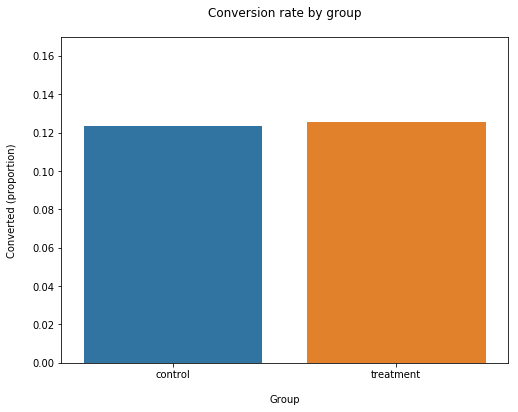

In [12]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test_df['group'], y=ab_test_df['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

# Basic Statistics: Is Experiment better or worse than Control?

1. Start by calculating: mean, standard deviation and standard error (SE) for each group

**Tips**
Learn more about python library scipy, in particular **stats**

*import scipy.stats as stats*

- Signature: **stats.sem**(a, axis=0, ddof=1, nan_policy='propagate')
    - Docstring: Compute standard error of the mean.
    - degrees of freedom should be Zero

In [13]:
stats.sem?

In [27]:
print(control_sample['converted'].mean())
print(control_sample['converted'].std())
print(stats.sem(control_sample['converted']))
print()
print(treatment_sample['converted'].mean())
print(treatment_sample['converted'].std())
print(stats.sem(treatment_sample['converted']))

0.12330508474576271
0.3288219098792094
0.004786187940680801

0.125635593220339
0.3314733314265011
0.004824780873372064


In [32]:
conversion_rates_control = control_sample['converted'].mean()
conversion_rates_treatment = treatment_sample['converted'].mean()

print(f'conversion rates of control: {round(conversion_rates_control, 3)}')
print(f'conversion rates of treatment: {round(conversion_rates_treatment, 3)}')


conversion rates of control: 0.123
conversion rates of treatment: 0.126


In [50]:
conversion_rates = ab_test_df.groupby('group')['converted']

conversion_rates = conversion_rates.agg({'conversion_rate':np.mean, 'std':np.std, 'se':stats.sem})
conversion_rates.columns = ['conversion_rate', 'std', 'se']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std,se
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


### What can you conclude from those results?

    - Similar conversion rate with very similar dispersion of data; seemingly almost no difference

# 4. Testing the hypothesis

- Explore library:
    - from statsmodels.stats.proportion import proportions_ztest, proportion_confint
    - see documentation: https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html

In [36]:
control_results = control_sample['converted']
treatment_results = treatment_sample['converted']

total_control = control_results.count()
total_treatment = treatment_results.count()

total_successes_for_each = [control_results.sum(), treatment_results.sum()]
total_observations = [total_control, total_treatment]

- Learn about what methods: proportions_ztest and proportion_confint return

- Run proportions_ztest method and proportion_confint with your data
    - significance level should be 0.05

In [49]:
proportion_confint?

In [47]:
z_stat, pval = proportions_ztest(count=total_successes_for_each, nobs=total_observations)

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(count=total_successes_for_each, nobs=total_observations)

In [48]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


# Conclusions

- Difference between the two groups are statistically not significant (p-value = 0.732)
- Null-hypothesis accepted